## Flood frequency analysis
Here we apply concepts learned in the previous two notebooks (importing and exploring data) to a specific task, namely computing flood frequency at out gage site. This process involves the following sub-tasks:
* Grouping data by water year and computing max daily discharge by year
* Computing return intervals and probability of flood recurrences
* Computing a regression between return interval and 

In doing so, we explore the following Python concepts:
* Sorting
* Ranking
* Grouping/summarizing
* 

In [1]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#Enable inline plots
%matplotlib inline

In [3]:
#Import the streamflow data CSV and format columns
df=pd.read_csv('GageData.csv',dtype={'site_no':'str'},parse_dates=['datetime'])

In [4]:
#Add year, month, and water_year columns
df['year'] = df['datetime'].map(lambda x: x.year)
df['month'] = df['datetime'].map(lambda x: x.month)
df['water_year'] = df['datetime'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)

In [5]:
#Compute flow in cms
df['MeanFlow_cms'] = df['MeanFlow_cfs'] * 0.028316847 

In [6]:
#Set the index to full date
df.index = df.datetime

In [7]:
#Create data slices for pre- and post-Falls Lake
dfPre = df[:'1980-01-01']
dfPost = df['1983-12-31':]

### Compute max annual flow
Compute max annual flow from our daily flow data. We do this by grouping our data on `water_year` and then computing the max daily discharge for each water year group, the results of which are stored in a new dataframe.

#### Step 1: Create a dataframe max discharge for each year

In [8]:
#Create a "GroupBy" object, using water_year as the grouping variable
byYear = df.groupby('water_year')
#From the GroupBy object, create an array of max values for each water year
arrMaxAnnual = byYear['MeanFlow_cms'].max()
#Display the first 5 records in the array
arrMaxAnnual[:5]

water_year
1930    300.158578
1931    264.762519
1932    212.376352
1933    237.861515
1934    461.564606
Name: MeanFlow_cms, dtype: float64

In [9]:
#Convert the array to a dataframe, renaming it to PeakFlow_cms
dfMA = arrMaxAnnual.to_frame(name="PeakFlow_cms")
dfMA.head()

,PeakFlow_cms
water_year,
1930,300.158578
1931,264.762519
1932,212.376352
1933,237.861515
1934,461.564606


#### Step 2. Rank and sort data by max discharge values
Before we can compute return interval (RI), we need to rank the max discharge values. We'll sort them as well, for easier viewing. 

In [10]:
# Rank discharge from highest to lowest, storing value in a "rank" column
dfMA['rank'] = dfMA.rank(ascending=False)
dfMA.sort_values(by='PeakFlow_cms',ascending=False,inplace=True)
dfMA.head()

,PeakFlow_cms,rank
water_year,,
1944,637.129057,1.0
1998,557.841886,2.0
1995,535.188408,3.0
2016,532.356724,4.0
1934,461.564606,5.0


#### Step 3. Compute Return Interval (RI) and Probability of Recurrence (PoR)
Recurrence interval is computed for each year by dividing the number of records (plus 1) by the year's rank. Probability of recurrence is the inverse of recurrence interval.

In [11]:
#Compute the number of records, e.g. the max of all rank values
countRecs = dfMA['rank'].max()

In [12]:
# Compute Return Interval (RI)
dfMA['RI'] = (countRecs + 1) / dfMA['rank']

In [13]:
# Compute probability of recurrence (Pe)
dfMA['Pe'] = 1 / dfMA['RI']

In [14]:
# Examine the results
dfMA.head()

,PeakFlow_cms,rank,RI,Pe
water_year,,,,
1944,637.129057,1.0,88.000000,0.011364
1998,557.841886,2.0,44.000000,0.022727
1995,535.188408,3.0,29.333333,0.034091
2016,532.356724,4.0,22.000000,0.045455
1934,461.564606,5.0,17.600000,0.056818


### Compute the regression using NumPy functions

In [15]:
#Set variables 
x = dfMA['RI']
y = dfMA['PeakFlow_cms']

logx = np.log(x)

In [16]:
# Compute the slope and intercept using the polyfit function
regSlope, regIntercept = np.polyfit(np.log(x), y, 1)
print(regSlope, regIntercept)

118.000954287 128.192588643


In [17]:
#Convert the regression components into a printable formula
regText = "y = {0:.1f}x + {1:.1f}".format(regSlope,regIntercept)
print(regText)

y = 118.0x + 128.2


In [18]:
# Compute p
p = np.poly1d(regSlope, regIntercept)
print(p.r)

[ 118.00095429]


In [19]:
# Apply the regression to 100, 500, and 1000 year return intervals (x values)

#Create a series of the return intervals to compute
sFloodRI = pd.Series([100,500,1000],name='FloodRI')

#Compute the 30-year probability of exceedence for each return interval
sFloodPe30 = 1-(1-(1/sFloodRI))**30

#Compute the peak flow associated with those Pe values
sFloodPeak_cms = regIntercept * sFloodPe30 + regSlope

#Combine into a single dataframe
dfFlood = pd.concat([sFloodRI,sFloodPe30,sFloodPeak_cms],axis=1)
dfFlood.columns = ['RI','Pe','PeakFlow_cms']

#Show the dataframe
dfFlood

,RI,Pe,PeakFlow_cms
0,100,0.260300,151.369437
1,500,0.058292,125.473563
2,1000,0.029569,121.791485


### Plotting
https://seaborn.pydata.org/tutorial/regression.html
https://seaborn.pydata.org/generated/seaborn.regplot.html#seaborn.regplot

In [20]:
#Set the style to use Seaborn
sns.set(color_codes=True,font_scale=2)

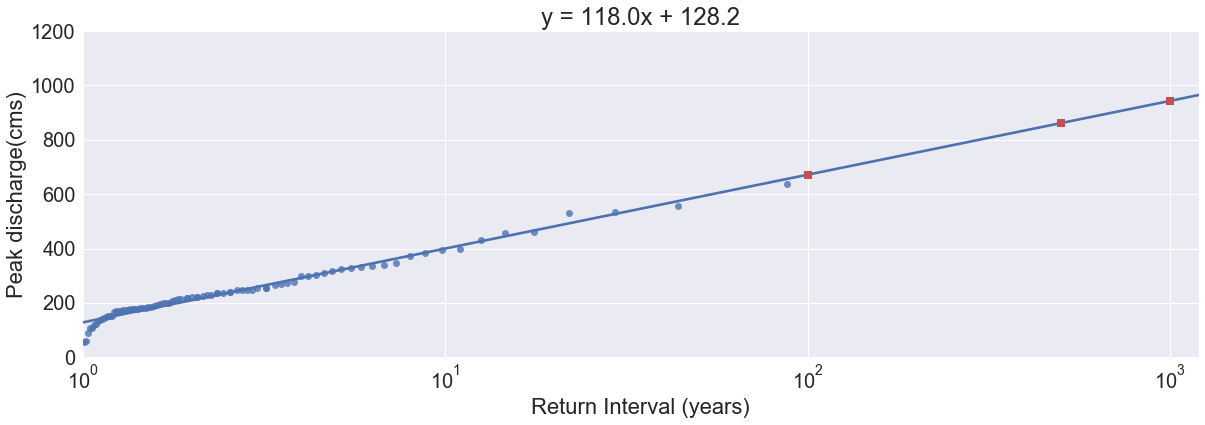

In [21]:
#Create the canvas (fig) and axes (ax) objects, setting the figure size
fig, ax = plt.subplots(figsize=(20,6))

#Set axis properties
ax.set(xlim=(1,1200),
       ylim=(0,1200),
       xscale ="log",
       label=regText
      )

#Plot the data
ax = sns.regplot(x='RI',
                 y='PeakFlow_cms',
                 data=dfMA,
                 logx=True,
                 fit_reg=True,
                 ci=None)

#Set the axis labels.
ax.set(xlabel='Return Interval (years)', 
       ylabel='Peak discharge(cms)',
       title=regText
      )

#Compute Peak discharges from 100, 500, and 1000 year intervals
for RI in (100,500,1000):
    #Compute peak discharge from RI
    peakFlow = (np.log(RI) * regSlope) + regIntercept
    #Add to the plot
    ax.plot(RI,peakFlow,'rs',markersize=8) #'rs' = red square markers

## Plot pre vs post Falls Lake 1980 data

In [22]:
#Set the TimeSet variable to pre or post, using index (i.e. year) values 
dfMA.loc[dfMA.index < 1980,'TimeSet'] = 'PreFallsLake'
dfMA.loc[dfMA.index >= 1984,'TimeSet'] = 'PostFallsLake'

C:\Users\jpfay\AppData\Local\conda\conda\envs\scipy\lib\site-packages\seaborn\regression.py:277: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


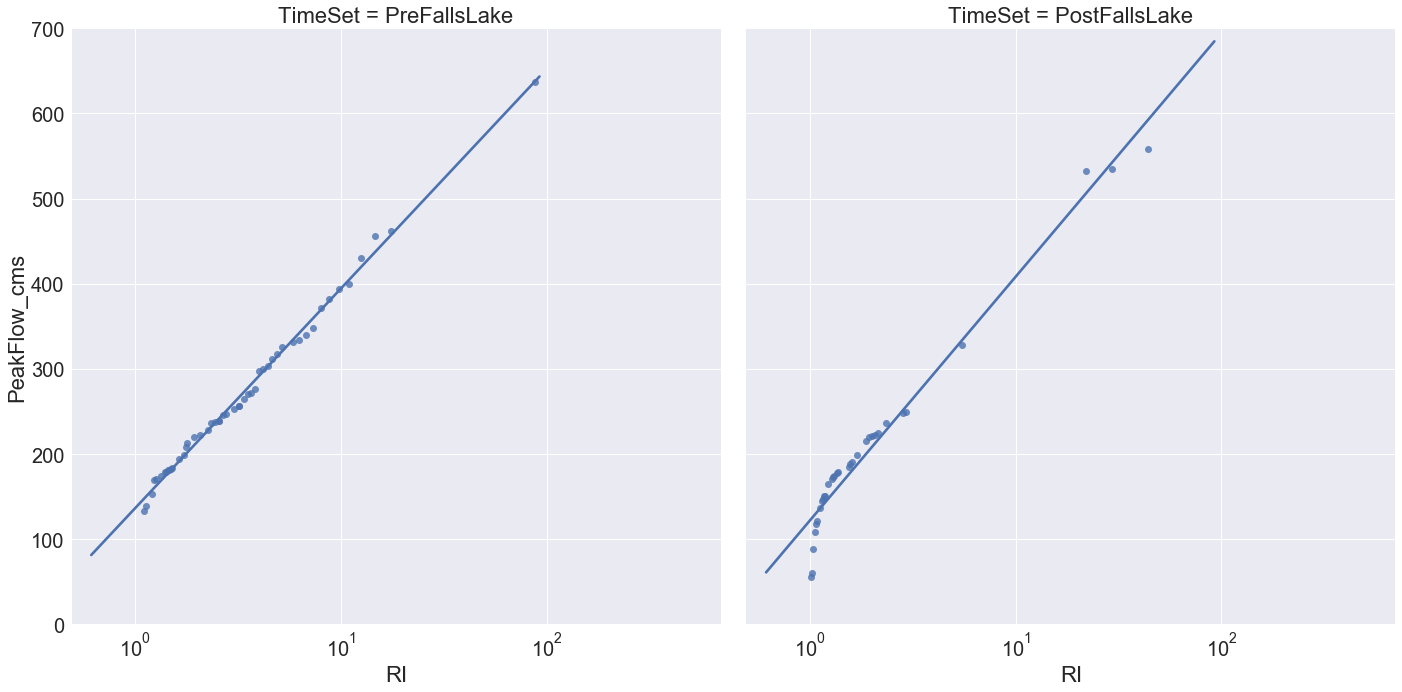

In [24]:
#Plot multiple frames using Seaborn's FacetGrids

#Create the Facets based on values in the TimeSet field (Set above)
g = sns.FacetGrid(dfMA,col='TimeSet',size=10,legend_out=True)

#Add the regression plot to each facet
g.map(sns.regplot,'RI','PeakFlow_cms',
      data=dfMA,
      logx=True,
      fit_reg=True,
      ci=None)

#Set the axis values
for ax in g.axes.flat:
    ax.set(xlim=(0,700),  
           ylim=(0,700),
           xscale ="log"
          )

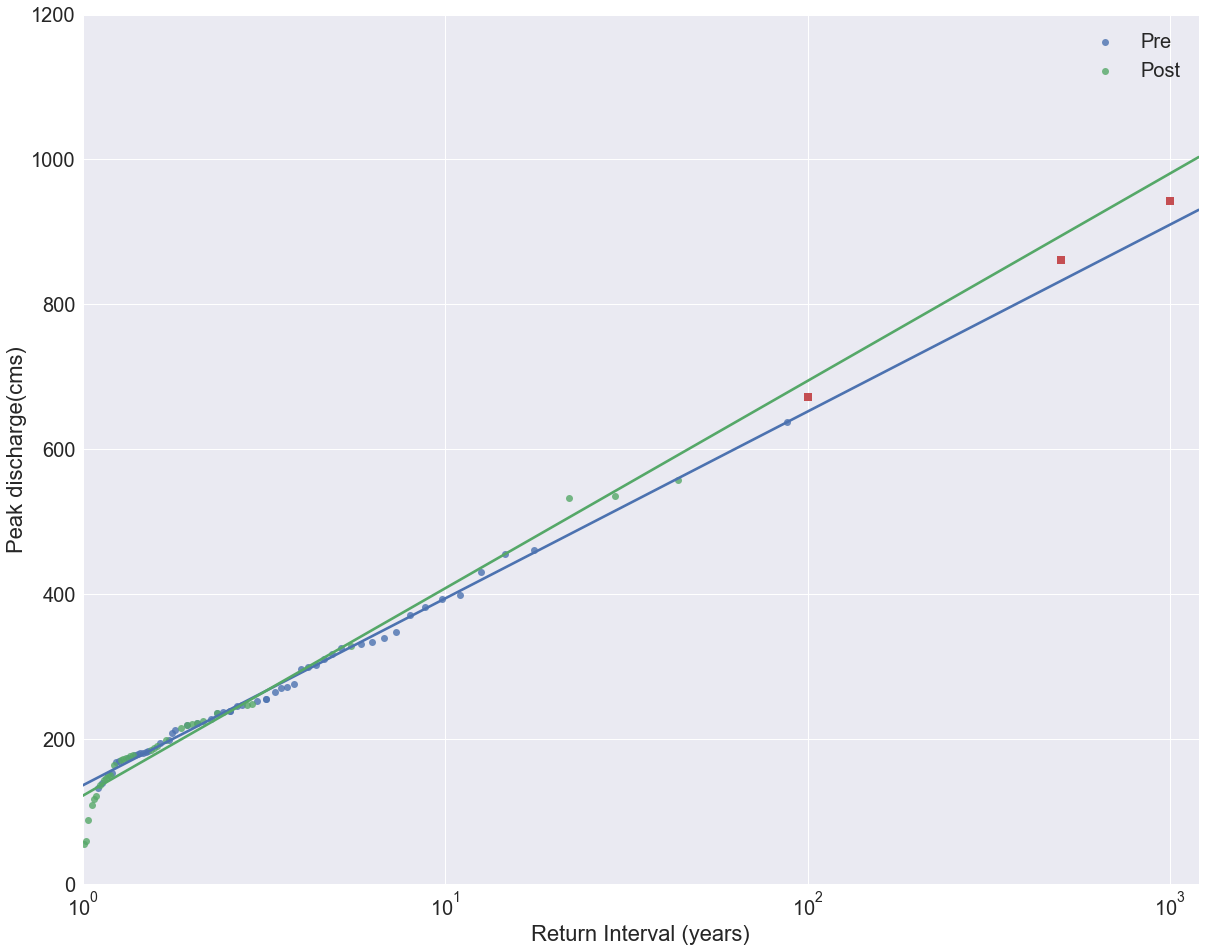

In [26]:
#Create the canvas (fig) and axes (ax) objects, setting the figure size
fig, ax = plt.subplots(figsize=(20,16))

#Set axis properties
ax.set(xlim=(1,1200),
       ylim=(0,1200),
       xscale ="log"
      )

#Plot the data
ax = sns.regplot(x='RI',
                 y='PeakFlow_cms',
                 data=dfMA.loc[dfMA.index < 1980],
                 logx=True,
                 fit_reg=True,
                 ci=None,
                 label='Pre'
                )

#Plot the data
ax = sns.regplot(x='RI',
                 y='PeakFlow_cms',
                 data=dfMA.loc[dfMA.index >= 1984],
                 logx=True,
                 fit_reg=True,
                 ci=None,
                 label='Post'
                )

#Set the axis labels.
ax.set(xlabel='Return Interval (years)', 
       ylabel='Peak discharge(cms)'
      )

ax.legend()

#Compute Peak discharges from 100, 500, and 1000 year intervals
for RI in (100,500,1000):
    #Compute peak discharge from RI
    peakFlow = (np.log(RI) * regSlope) + regIntercept
    #Add to the plot
    ax.plot(RI,peakFlow,'rs',markersize=8) #'rs' = red square markers

In [30]:
#Filter the data
dfPre = df[:'1979-12-31']

#Sort the records
dfPre.sort_values(by='MeanFlow_cms',ascending=False)

#Group data on water_year
byYear = df.groupby('water_year')

#Compute a series of max annual flow from the grouped data
sPeakFlow = byYear['MeanFlow_cms'].max()
sPeakFlow.name = "PeakFlow_cms"

#Compute rankings
sRank = sPeakFlow.rank(ascending=False)
sRank.name = "rank"

#Combine peakflow and rank series into a dataframe
dfPreMA = pd.concat([sPeakFlow,sRank],axis='columns')

#Count the number of years 
countRecs = dfPreMA['rank'].max()

#Compute Return Interval (RI)
dfPreMA['RI'] = (countRecs + 1) / dfPreMA['rank']

#Compute Probability of exceedance (Pe)
dfPreMA['Pe'] = 1 / dfPreMA['RI']